In [1]:
import imufusion
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import noisereduce as nr

ImportError: Numba needs NumPy 1.21 or less

In [ ]:
my_data = np.genfromtxt('./accelGyroLogBusTest.csv',delimiter=',')

# Get absolute acceleration

In [4]:
#del my_data[1::2]

In [ ]:
timestamp = [my_data[0,0]]
tot_num = len(my_data[:,0])
time_index = 1
while time_index<tot_num:
    timestamp.append(timestamp[time_index-1]+my_data[time_index,0])
    time_index += 1

In [ ]:
t_interval_list = my_data[:, 0]
gyroscopeR = my_data[:, 4:7]
accelerometer = my_data[:, 1:4]

In [ ]:
sample_rate = (timestamp[len(timestamp)-1]-timestamp[0])/len(timestamp)

In [ ]:
sample_rate

In [9]:
gyroscope = np.degrees(gyroscopeR)

In [10]:
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], sample_rate)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

In [11]:
r = R.from_euler('xyz', euler, degrees=True)
absAccel = r.apply(accelerometer)

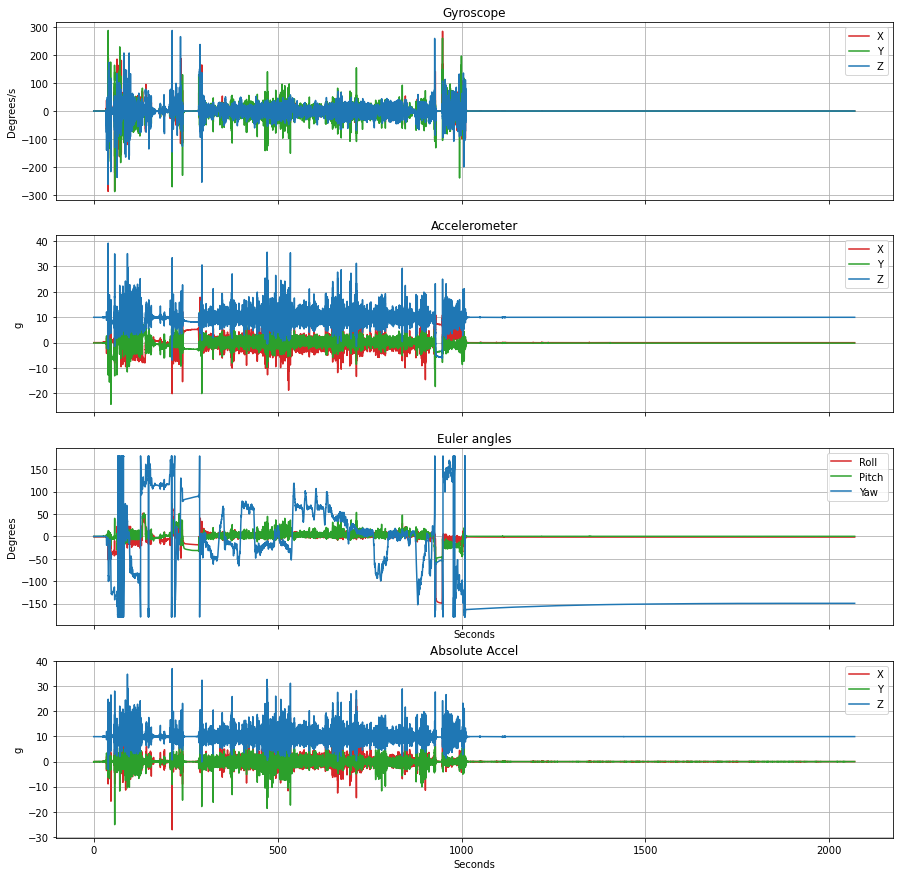

In [12]:
_, axes = plt.subplots(nrows=4, sharex=True, figsize=(15,15))

axes[0].plot(timestamp, gyroscope[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, gyroscope[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Z")
axes[0].set_title("Gyroscope")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

axes[1].plot(timestamp, accelerometer[:, 0], "tab:red", label="X")
axes[1].plot(timestamp, accelerometer[:, 1], "tab:green", label="Y")
axes[1].plot(timestamp, accelerometer[:, 2], "tab:blue", label="Z")
axes[1].set_title("Accelerometer")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()

axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_title("Euler angles")
axes[2].set_xlabel("Seconds")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

axes[3].plot(timestamp, absAccel[:, 0], "tab:red", label="X")
axes[3].plot(timestamp, absAccel[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp, absAccel[:, 2], "tab:blue", label="Z")
axes[3].set_title("Absolute Accel")
axes[3].set_xlabel("Seconds")
axes[3].set_ylabel("g")
axes[3].grid()
axes[3].legend()

In [13]:
absAccel

array([[-3.87563368e-02, -1.82841028e-01,  9.95062617e+00],
       [-3.80456937e-02, -1.79118539e-01,  9.95069661e+00],
       [-3.73591666e-02, -1.75485548e-01,  9.95076395e+00],
       ...,
       [ 5.50125238e-03,  1.36177098e-03,  9.94158267e+00],
       [ 5.46736838e-03,  1.42562589e-03,  9.94158268e+00],
       [ 5.63388413e-04,  1.18899806e-02,  9.95383673e+00]])

In [14]:
# fig = plt.figure(figsize=(50,20))
# plt.plot(timestamp, absAccel[:, 0], "tab:red", label="X")
# plt.plot(timestamp, absAccel[:, 1], "tab:green", label="Y")
# plt.plot(timestamp, absAccel[:, 2], "tab:blue", label="Z")
# plt.axhline(calib_g[0])
# plt.axhline(calib_g[1])
# plt.axhline(calib_g[2])
# plt.grid(which='minor', alpha=0.2)
# plt.grid(which='major', alpha=0.5)

In [15]:
#calib_g

# Calibrate absolute acceleration

In [16]:
index = next(x for x, val in enumerate(timestamp) if val>3)
accelCalib = np.empty(absAccel.shape)
calib_g = []
for indAxis in [0,1,2]:
    noise = sum(absAccel[:index,indAxis])/index
    accelCalib[:,indAxis] = absAccel[:,indAxis] - noise
    calib_g.append(noise)

In [17]:
totNum = len(t_interval_list)
velo_list = np.empty(absAccel.shape)
posi_list = np.empty(absAccel.shape)
velo_list[0] = [0,0,0]
posi_list[0] = [0,0,0]

for indAxis in [0,1,2]:
    i=0
    while i<totNum:
        if i > 0:
            newVelo = velo_list[i-1,indAxis] + accelCalib[i,indAxis] * t_interval_list[i]
            if abs(newVelo) < 0:
                velo_list[i,indAxis]=0
            else:
                velo_list[i,indAxis]=newVelo
            posi_list[i,indAxis]=(posi_list[i-1,indAxis] + velo_list[i,indAxis] * t_interval_list[i])
        i+=1

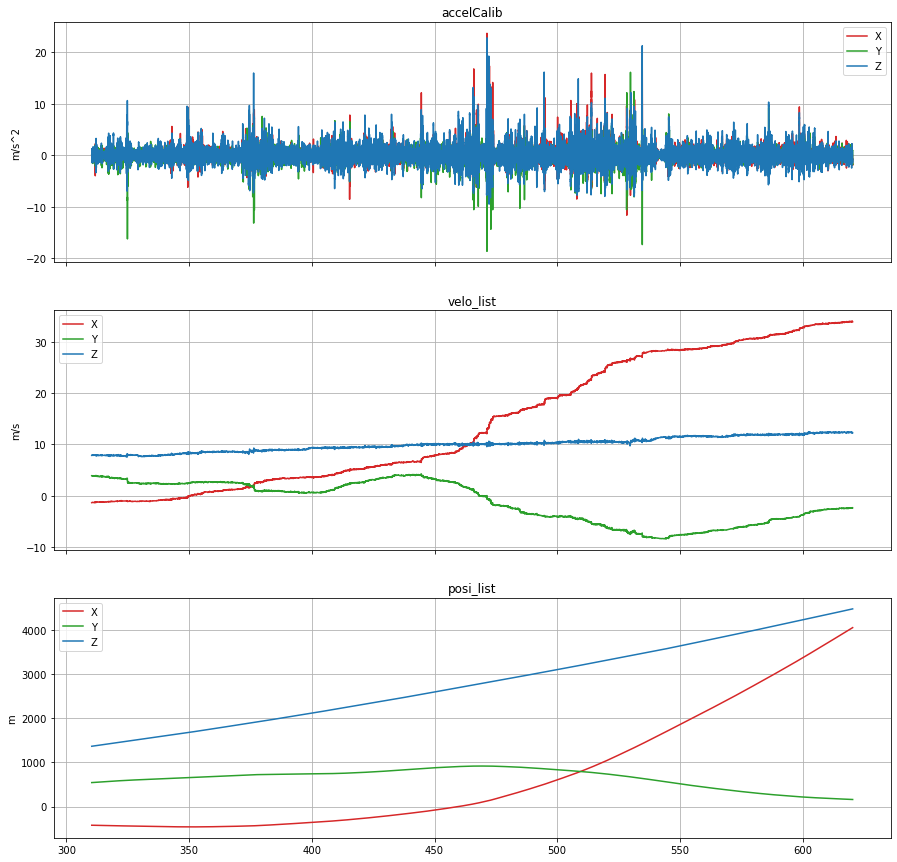

In [18]:
_, axesR = plt.subplots(nrows=3, sharex=True, figsize=(15,15))
npts0 = 500*5*60
npts1 = 500*10*60

axesR[0].plot(timestamp[npts0:npts1], accelCalib[npts0:npts1, 0], "tab:red", label="X")
axesR[0].plot(timestamp[npts0:npts1], accelCalib[npts0:npts1, 1], "tab:green", label="Y")
axesR[0].plot(timestamp[npts0:npts1], accelCalib[npts0:npts1, 2], "tab:blue", label="Z")
axesR[0].set_title("accelCalib")
axesR[0].set_ylabel("m/s^2")
axesR[0].grid()
# axesR[0].set_xlim(0,60)
axesR[0].legend()

axesR[1].plot(timestamp[npts0:npts1], velo_list[npts0:npts1, 0], "tab:red", label="X")
axesR[1].plot(timestamp[npts0:npts1], velo_list[npts0:npts1, 1], "tab:green", label="Y")
axesR[1].plot(timestamp[npts0:npts1], velo_list[npts0:npts1, 2], "tab:blue", label="Z")
axesR[1].set_title("velo_list")
axesR[1].set_ylabel("m/s")
axesR[1].grid()
#axesR[1].set_xlim(0,60)
axesR[1].legend()

axesR[2].plot(timestamp[npts0:npts1],posi_list[npts0:npts1, 0], "tab:red", label="X")
axesR[2].plot(timestamp[npts0:npts1],posi_list[npts0:npts1, 1], "tab:green", label="Y")
axesR[2].plot(timestamp[npts0:npts1],posi_list[npts0:npts1, 2], "tab:blue", label="Z")
axesR[2].set_title("posi_list")
axesR[2].set_ylabel("m")
axesR[2].grid()
#axesR[2].set_xlim(0,60)
#axesR[2].set_ylim(-5, 5)
axesR[2].legend()

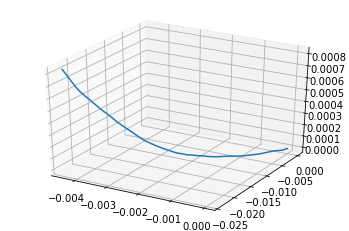

In [19]:
fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

# defining all 3 axes

x = posi_list[:1000, 0]
y = posi_list[:1000, 1]
z = posi_list[:1000, 2]
# plotting
ax.plot3D(x, y, z)
plt.show()


# Noise reduction

## nr on raw acceleration

In [26]:
nSampleSec = int(1/sample_rate)
reduced_noise_raw = np.empty(accelerometer.shape)
for axis in [0, 1, 2]:
    reduced_noise_raw[:, axis] = nr.reduce_noise(y=accelerometer[:, axis], sr=nSampleSec, n_std_thresh_stationary=1.5, stationary=True)

ValueError: time_mask_smooth_ms needs to be at least 530ms

In [20]:
r = R.from_euler('xyz', euler, degrees=True)
absAccel_nrOnRaw = r.apply(reduced_noise_raw)

(1000000, 3)

In [22]:
nSampleSec

483